# <font color='blue'>**LABORATORIO 1. Reconocimiento de rostros usando VISIÓN COMPUTACIONAL CLÁSICA**

<font color='red'>Integrantes: 
    

* Daniel Velasco Rodriguez 2215456
* Ruben Dario Fierro 2215789






<font color='blue'>**(15%) Parte 1. Creando su propio dataset.**

Cree un conjunto de imagenes de su rostros y de sus compañeros de grupo. Este conjunto de datos le debe servir para entrenar y validar su red neuronal clasica MLP (Multi Layer Perceptron). A la hora de obtener las imagenes tenga en cuenta aplicarles variaciones de tal manera que su red sea capaz de "generalizar de una mejor manera. Algunas de las variaciones propuestas son: rotación, traslación e iluminación.  A la hora de rotar el rostro tenga en cuenta no pasarse de +/-15°. Tenga en cuenta que las fotos se deben tomar de manera frontal a la camara, pero pueden tener cierttos angulos de giro como los mostrados en la siguiente figura:

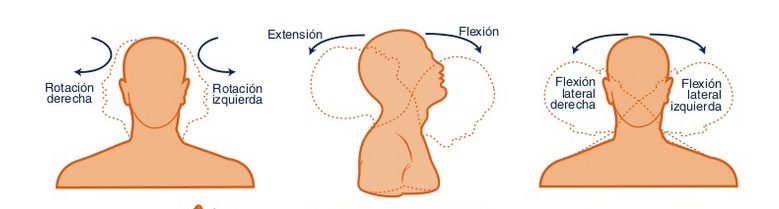

El numero de imagenes es dejado a consideración de cada grupo ( con una búsqueda rápida en google, pordrían definir un numero correcto de imágenes).

Dividan el conjunto de imagenes en imagenes de entrenamiento (80%) e imagenes de validación (20%)


<font color='blue'>**(5%) Parte 2. Pre-procesamiento.**

Un buen pre-procesamiento puede mejorar su clasificador.
Una tarea clasica de pre-procesamiento puede consistir en dos pasos:
* Elimine ruido a las imagenes
* Convierta a escala de grises
* Normalice las imagenes

Realice un código que le permita cumplir con este paso de preprocesamiento sobre los conjuntos de imagenes que serviran para entrenamiento y validación.

<font color='blue'>**(20%) Parte 3. Detectores/Descriptores**

Extraiga las caracteristicas que van a alimentar a su ANN (Artificial Neural Network). Realice una o tres funciones diferentes que el permitan obtener 3 tipos de caracterisiticas: SIFT, SURF y HOG.

Tenga en cuenta el siguiente diagrama de bloques como base para el diseño de su arquitectura:

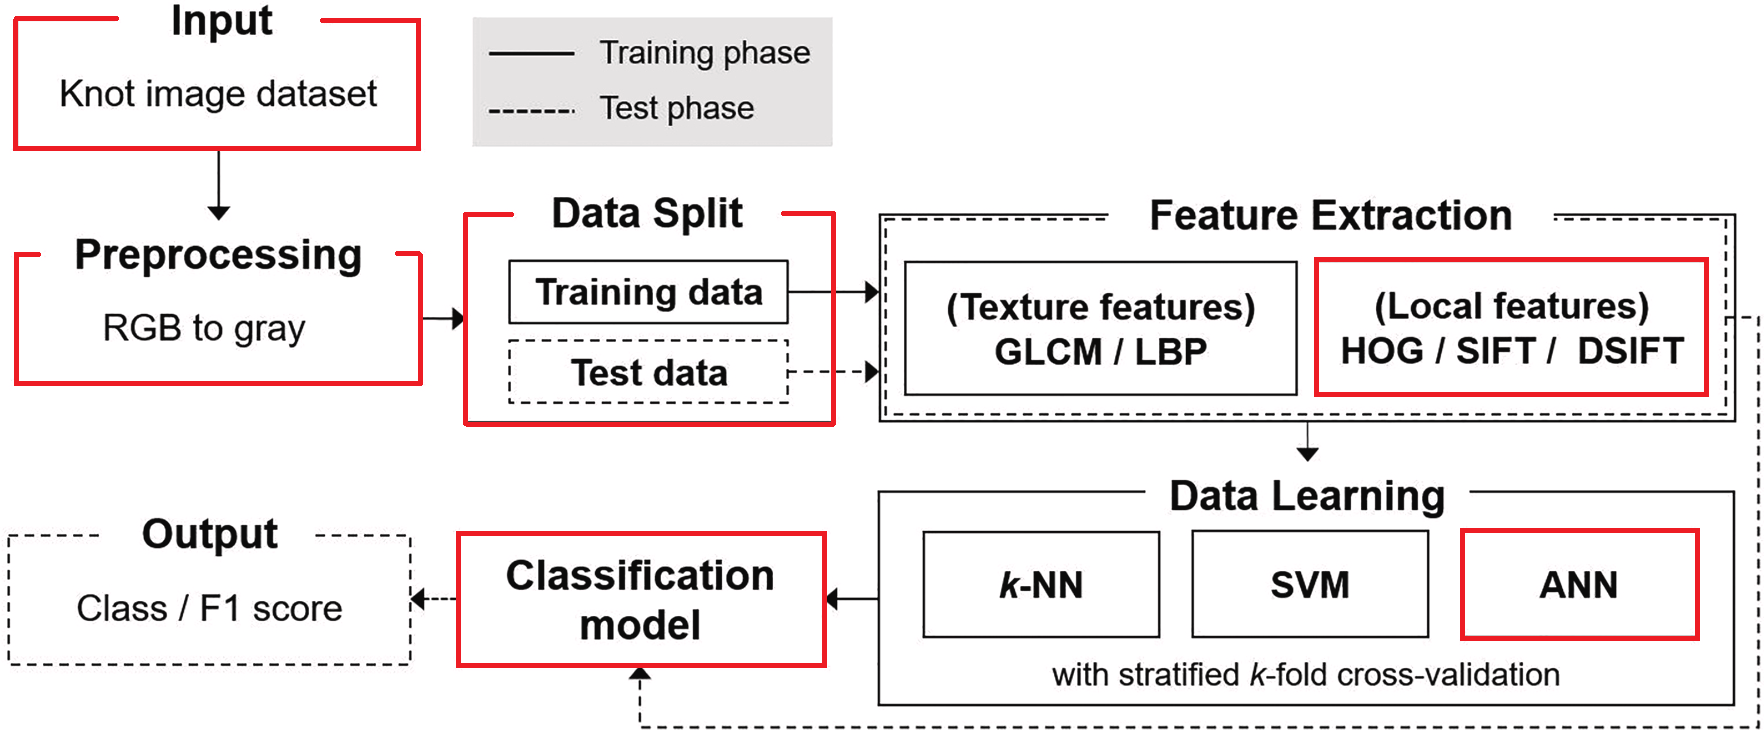


<font color='blue'> **(35%) Parte 4. ANN.**   

Cree y entrene una arquitectura MLP (Defina numero de neuronas, numero de capas y tipo de clasificador). Observe que los tamaños de los vectores que alimentarán la ANN, cambian dependiendo del descriptor usado.

Observe que el modelo por defecto carga los siguientes párametros:
<font color='red'>MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=123, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

Realice un estudio de los siguientes párametros y tome una decisión acerca de cambiar o no cambiar su valor: learning_rate, max_iter, momentum, n_iter_no_change y solver. 

Entrene su red.



<font color='blue'> **(25%) Parte 5. Metricas**

Utilice la llamada Matriz de Confusión para determinar  el grado de "ACCURACY" que tuvo su red. 
Realice una tabla comparativa de los resultados obtenidos haciendo uso de los diferentes descriptores.
Escriba al menos 3 conclusiones acerca de las técnicas aqui usadas que permitan conocer las "bondades" y los "defectos" de dichas técnicas. 



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **LIBRERIAS**

**ESCOGER SIFT O SURF**

In [ ]:
#SIFT 
!pip install opencv-contrib-python==4.4.0.44    #SIFT

#SURF
#!pip install opencv-contrib-python==3.4.2.17     #SURF

In [ ]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd
import pprint
import cv2
import joblib
from PIL import Image

from sklearn.metrics import plot_confusion_matrix, r2_score, mean_absolute_error, mean_squared_error, classification_report, confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import make_scorer, precision_score, precision_recall_curve, plot_precision_recall_curve, plot_roc_curve, roc_auc_score, roc_curve, f1_score, accuracy_score, recall_score

from google.colab.patches import cv2_imshow
from skimage.feature import hog, local_binary_pattern
from skimage.io import imread
from skimage.transform import resize
pp = pprint.PrettyPrinter(indent=4)
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from keras.preprocessing.image import img_to_array
from sklearn.metrics import confusion_matrix,accuracy_score
from scipy.cluster.vq import kmeans,vq
from sklearn.preprocessing import StandardScaler

# **FUNCIONES**

In [ ]:
 #Probar que si esta activada la GPU
 device = tf.test.gpu_device_name()
 if device!='/device:GPU:0':
   raise SystemError('No se encontro una GPU')
 print('GPU encontrada:{}'.format(device))

GPU encontrada:/device:GPU:0


In [ ]:
#FUNCION PARA PREPROCESAR LA IMAGEN EN DIMENSION Y RUIDO

def resize_imagen(ruta_imagen, height, width):
  img = cv2.imread(ruta_imagen)
  img = resize(img, (height,width))
  img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
  
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img_gray = cv2.normalize(img_gray, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

  img_blur = cv2.blur(img, (3,3))
  img_gray_blur = cv2.blur(img_gray, (3,3))

  return img_gray_blur, img_blur

#FUNCION PARA QUE LA SALIDA QUEDE CON LA ETIQUETA
def salida_nombres (predicciony):

  lista_nombres = []

  for i in range(len(predicciony)):
    if predicciony[i] == 0:
      lista_nombres.append('ruben')
    else:
      lista_nombres.append('daniel') 

  return lista_nombres

#FUNCION PARA GUARDAR LOS DATOS EN UN ARCHIVO PK
def save_data(img_rgb, img_rgb_blur, img_grayscale, img_grayscale_blur, label, nombre_archivo):

  data = dict()

  data['img_rgb'] = img_rgb
  data['img_rgb_blur'] = img_rgb_blur
  data['img_grayscale'] = img_grayscale
  data['img_grayscale_blur'] = img_grayscale_blur
  data['label'] = label
  data['nombre_archivo'] = nombre_archivo
  
  joblib.dump(data, data['nombre_archivo'])

#FUNCIÓN SCORES

def train_val(y_train_hog, y_train_pred, y_test_hog, y_pred):
    
    scores = {"train_set": {"Accuracy" : accuracy_score(y_train_hog, y_train_pred),
                            "Precision" : precision_score(y_train_hog, y_train_pred),
                            "Recall" : recall_score(y_train_hog, y_train_pred),                          
                            "f1" : f1_score(y_train_hog, y_train_pred)},
    
              "test_set": {"Accuracy" : accuracy_score(y_test_hog, y_pred),
                           "Precision" : precision_score(y_test_hog, y_pred),
                           "Recall" : recall_score(y_test_hog, y_pred),                          
                           "f1" : f1_score(y_test_hog, y_pred)}}
    
    return pd.DataFrame(scores)

#HOG PARA IMG DE PRUEBA
def hog_features2(matriz_imagenes_gris):
    
    descriptores_hog_prueba = []
    i= 0
    for foto in range(0,len(matriz_imagenes_gris),1):

        fd, hogg = hog(matriz_imagenes_gris[i], orientations=9, pixels_per_cell=(4,4), cells_per_block=(2,2), block_norm='L2', visualize=True, multichannel=True)
        print(hogg.shape)
        print('Vector de caracteristicas imagen:',fd.shape)
        print('Foto #:{}'.format(i))
        descriptores_hog_prueba.append(fd)
        i += 1
        
    return descriptores_hog_prueba

# **CARGA DE IMAGENES**

In [ ]:
categorias = []

imagenes = []
imagenes_blur = []

imagenes_gray = []
imagenes_gray_blur = []

labels = []

height = 200
width = 200

In [ ]:
categorias = os.listdir('/content/drive/MyDrive/Colab Notebooks/VISION COMPUTACIONAL/DATASET DE IMAGENES LAB 1/DATASET_RGB')
print(categorias)

['ruben', 'daniel']


In [ ]:
#CREACIÓN DATASET
#PREPROCESAMIENTO DE LAS IMAGENES
estrategia = tf.device('/device:GPU:0')
with estrategia: 
  i = 0
  for carpeta in categorias:
      for imagen in os.listdir('/content/drive/MyDrive/Colab Notebooks/VISION COMPUTACIONAL/DATASET DE IMAGENES LAB 1/DATASET_RGB'+"/"+carpeta):

          img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/VISION COMPUTACIONAL/DATASET DE IMAGENES LAB 1/DATASET_RGB'+"/"+carpeta+"/"+imagen)
          img = resize(img, (height,width))
          img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

          img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
          img_gray = cv2.normalize(img_gray, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

          img_blur = cv2.blur(img, (3,3))
          img_gray_blur = cv2.blur(img_gray, (3,3))

          imagenes.append(img)
          imagenes_gray.append(img_gray)
          imagenes_blur.append(img_blur)
          imagenes_gray_blur.append(img_gray_blur)

          labels.append(i)

      i += 1

# se demora por ahi 18 minutos

In [ ]:
print(labels)

**0 --> Ruben**

**1 --> Daniel**

In [ ]:
save_data(imagenes, imagenes_blur, imagenes_gray, imagenes_gray_blur, labels, 'dataset200x200')

# **SI EL ARCHIVO YA EXISTE CONTINUA AQUI**

In [ ]:
### SI EL ARCHIVO YA EXISTE CONTINUAR AQUI

ruta = '/content/dataset200x200'

data = joblib.load(ruta)

x = np.array(data['img_rgb'])
x_gray = np.array(data['img_grayscale'])

x_blur = np.array(data['img_rgb_blur'])
x_gray_blur = np.array(data['img_grayscale_blur'])

y = np.array(data['label'])

print('shape x: ', x.shape, '\n')
print('shape x_gray: ', x_gray.shape, '\n')
print('shape x_blur: ', x_blur.shape, '\n')
print('shape x_gray_blur: ', x_gray_blur.shape, '\n')
print('y: ', y.shape)

shape x:  (147, 200, 200, 3) 

shape x_gray:  (147, 200, 200) 

shape x_blur:  (147, 200, 200, 3) 

shape x_gray_blur:  (147, 200, 200) 

y:  (147,)


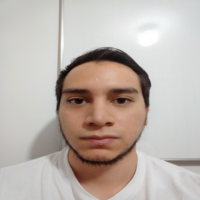

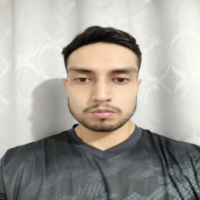

In [ ]:
cv2_imshow(x[0]) 
cv2_imshow(x[77]) 

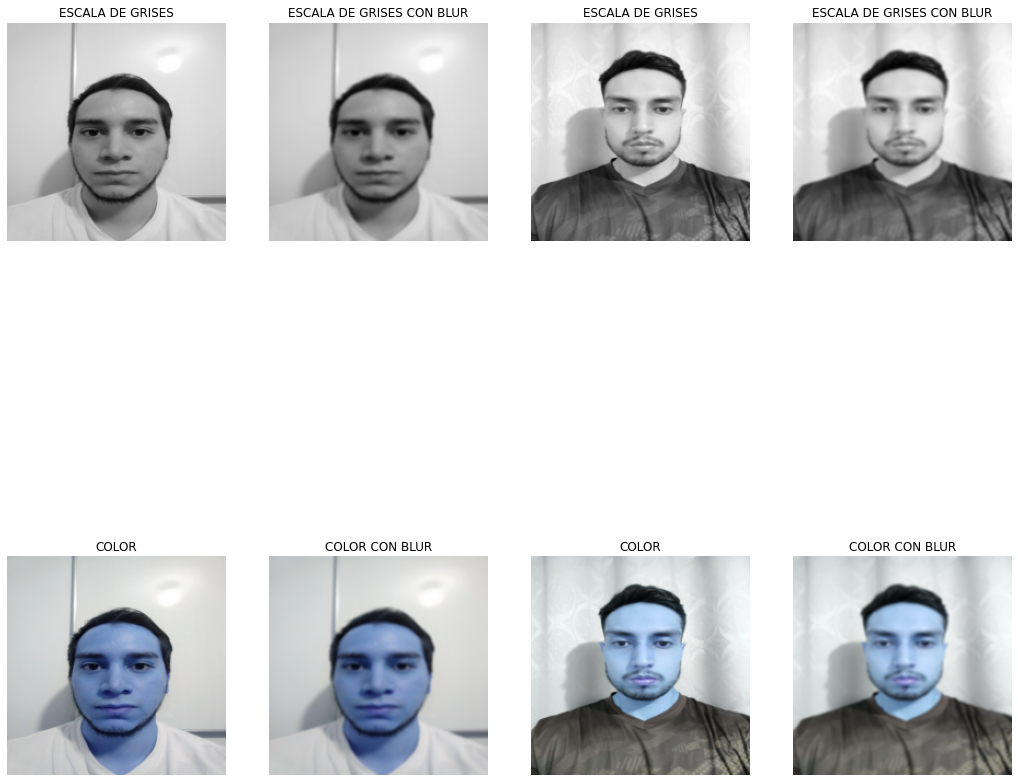

In [ ]:
plt.figure(figsize=(18,18))
plt.subplot(2,4,1), plt.imshow(x_gray[0], cmap='gray'), plt.title('ESCALA DE GRISES'), plt.axis('off')
plt.subplot(2,4,2), plt.imshow(x_gray_blur[0], cmap='gray'), plt.title('ESCALA DE GRISES CON BLUR'), plt.axis('off')
plt.subplot(2,4,3), plt.imshow(x_gray[77], cmap='gray'), plt.title('ESCALA DE GRISES'), plt.axis('off')
plt.subplot(2,4,4), plt.imshow(x_gray_blur[77], cmap='gray'), plt.title('ESCALA DE GRISES CON BLUR'), plt.axis('off')


plt.subplot(2,4,5), plt.imshow(x[0]), plt.title('COLOR'), plt.axis('off')
plt.subplot(2,4,6), plt.imshow(x_blur[0]), plt.title('COLOR CON BLUR'), plt.axis('off')
plt.subplot(2,4,7), plt.imshow(x[77]), plt.title('COLOR'), plt.axis('off')
plt.subplot(2,4,8), plt.imshow(x_blur[77]), plt.title('COLOR CON BLUR'), plt.axis('off')

plt.show()

#**SEPARACIÓN DE LOS DATOS PARA ENTRENAMIENTO Y VALIDACION**

In [ ]:
#-------------------- SEPARACION DE LOS DATOS
x_train, x_test, y_train, y_test = train_test_split(x_gray_blur, y, test_size=0.2, shuffle=True, random_state=42)

print('x_train: ', x_train.shape)
print('y_train: ', y_train.shape)
print('x_test: ', x_test.shape)
print('y_test: ', y_test.shape)


x_train:  (117, 200, 200)
y_train:  (117,)
x_test:  (30, 200, 200)
y_test:  (30,)


# **HOG**

In [ ]:
#HOG

height = 200
width = 200
descriptores_hog = []

def hog_features(matriz_imagenes_gris):
    i= 0
    for foto in range(0,len(matriz_imagenes_gris),1):

        fd, hogg = hog(matriz_imagenes_gris[i], orientations=9, pixels_per_cell=(4,4), cells_per_block=(2,2), block_norm='L2', visualize=True, multichannel=True)
        print(hogg.shape)
        print('Vector de caracteristicas imagen:',fd.shape)
        print('Foto #:{}'.format(i))
        descriptores_hog.append(fd)
        i += 1
        
    return descriptores_hog


In [ ]:
#AUMENTAR 1 DIMENSIÓN
##PARA HOG SE NECESITA EJ: [118,150,150,1]

x_train_hog = x_train.reshape(x_train.shape[0],height,width,1)
x_test_hog = x_test.reshape(x_test.shape[0],height,width,1)
y_train_hog = y_train
y_test_hog = y_test

print('x_train_hog:{}'.format(x_train_hog.shape))
print('x_test_hog:{}'.format(x_test_hog.shape))
print('y_train_hog:{}'.format(y_train_hog.shape))
print('y_test_hog:{}'.format(y_test_hog.shape))


x_train_hog:(117, 200, 200, 1)
x_test_hog:(30, 200, 200, 1)
y_train_hog:(117,)
y_test_hog:(30,)


In [ ]:
hog_train = hog_features(x_train_hog)
hog_train = np.asarray(hog_train)

print('hog_train: ', hog_train.shape)

(200, 200)
Vector de caracteristicas imagen: (86436,)
Foto #:0
(200, 200)
Vector de caracteristicas imagen: (86436,)
Foto #:1
(200, 200)
Vector de caracteristicas imagen: (86436,)
Foto #:2
(200, 200)
Vector de caracteristicas imagen: (86436,)
Foto #:3
(200, 200)
Vector de caracteristicas imagen: (86436,)
Foto #:4
(200, 200)
Vector de caracteristicas imagen: (86436,)
Foto #:5
(200, 200)
Vector de caracteristicas imagen: (86436,)
Foto #:6
(200, 200)
Vector de caracteristicas imagen: (86436,)
Foto #:7
(200, 200)
Vector de caracteristicas imagen: (86436,)
Foto #:8
(200, 200)
Vector de caracteristicas imagen: (86436,)
Foto #:9
(200, 200)
Vector de caracteristicas imagen: (86436,)
Foto #:10
(200, 200)
Vector de caracteristicas imagen: (86436,)
Foto #:11
(200, 200)
Vector de caracteristicas imagen: (86436,)
Foto #:12
(200, 200)
Vector de caracteristicas imagen: (86436,)
Foto #:13
(200, 200)
Vector de caracteristicas imagen: (86436,)
Foto #:14
(200, 200)
Vector de caracteristicas imagen: (8643

In [ ]:
hog_test = hog_features(x_test_hog)
hog_test = np.asarray(hog_test[117:])

print('hog_test: ', hog_test.shape)

(200, 200)
Vector de caracteristicas imagen: (86436,)
Foto #:0
(200, 200)
Vector de caracteristicas imagen: (86436,)
Foto #:1
(200, 200)
Vector de caracteristicas imagen: (86436,)
Foto #:2
(200, 200)
Vector de caracteristicas imagen: (86436,)
Foto #:3
(200, 200)
Vector de caracteristicas imagen: (86436,)
Foto #:4
(200, 200)
Vector de caracteristicas imagen: (86436,)
Foto #:5
(200, 200)
Vector de caracteristicas imagen: (86436,)
Foto #:6
(200, 200)
Vector de caracteristicas imagen: (86436,)
Foto #:7
(200, 200)
Vector de caracteristicas imagen: (86436,)
Foto #:8
(200, 200)
Vector de caracteristicas imagen: (86436,)
Foto #:9
(200, 200)
Vector de caracteristicas imagen: (86436,)
Foto #:10
(200, 200)
Vector de caracteristicas imagen: (86436,)
Foto #:11
(200, 200)
Vector de caracteristicas imagen: (86436,)
Foto #:12
(200, 200)
Vector de caracteristicas imagen: (86436,)
Foto #:13
(200, 200)
Vector de caracteristicas imagen: (86436,)
Foto #:14
(200, 200)
Vector de caracteristicas imagen: (8643

# **ANN MLP HOG**

In [ ]:
#MODEL 1 - PARAMETROS DEFAULT
training_accuracy = []
test_accuracy = []

MLPC = MLPClassifier()
MLPC.fit(hog_train,np.array(y_train_hog))

training_accuracy.append(MLPC.score(hog_train,np.array(y_train_hog)))
test_accuracy.append(MLPC.score(hog_test,np.array(y_test_hog)))

In [ ]:
MLPC.get_params(deep=True)

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [ ]:
print("Training set score: {:.2f}".format(MLPC.score(hog_train,np.array(y_train_hog))))
print("Test set score: {:.2f}".format(MLPC.score(hog_test,np.array(y_test_hog))))

Training set score: 1.00
Test set score: 1.00



 [[17  0]
 [ 0 13]]
--------------------------------------------------------

               precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        13

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

--------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


,train_set,test_set
Accuracy,1.0,1.0
Precision,1.0,1.0
Recall,1.0,1.0
f1,1.0,1.0


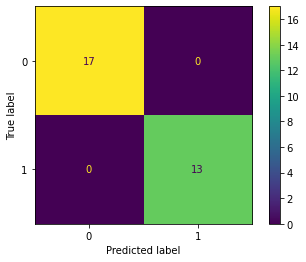

In [ ]:
# MPL 1
MLP_model_hog = MLPClassifier(random_state=2, max_iter=500)
MLP_model_hog.fit(hog_train, y_train_hog)
y_pred = MLP_model_hog.predict(hog_test)
y_train_pred = MLP_model_hog.predict(hog_train)



mlp_f1 = f1_score(y_test_hog, y_pred)
mlp_acc = accuracy_score(y_test_hog, y_pred)
mlp_recall = recall_score(y_test_hog, y_pred)
mlp_auc = roc_auc_score(y_test_hog, y_pred)

print("\n",confusion_matrix(y_test_hog, y_pred))
print("--------------------------------------------------------")
print("\n",classification_report(y_test_hog, y_pred))
print("--------------------------------------------------------")

plot_confusion_matrix(MLP_model_hog, hog_test, y_test_hog)

train_val(y_train_hog, y_train_pred, y_test_hog, y_pred)

In [ ]:
#MODEL 2

training_accuracy = []
test_accuracy = []

hidden_layer_sizes = (100,)
activation = 'relu'                    #{identity, logistic, tanh, relu}
learning_rate = 'constant'                 #{constant, invscaling, adaptive -> SOLO CON sgd’}
max_iter = 200
momentum = 0.9                           #(0 a 1) SE CAMBIA CUANDO SE USA sgd
n_iter_no_change = 10                    #Only effective when solver=’sgd’ or ‘adam’
solver = 'adam'                         #{lbfgs, sgd, adam}


MLPC = MLPClassifier(hidden_layer_sizes = hidden_layer_sizes, activation = activation, learning_rate = learning_rate, 
                     max_iter = max_iter, momentum = momentum, n_iter_no_change = n_iter_no_change, 
                     solver = solver, random_state=1)


MLPC.fit(hog_train,np.array(y_train_hog))

training_accuracy.append(MLPC.score(hog_train,np.array(y_train_hog)))
test_accuracy.append(MLPC.score(hog_test,np.array(y_test_hog)))

print("Training set score: {:.2f}".format(MLPC.score(hog_train,np.array(y_train_hog))))
print("Test set score: {:.2f}".format(MLPC.score(hog_test,np.array(y_test_hog))))

Training set score: 1.00
Test set score: 1.00


## **PRUEBA DE MODELO HOG**

In [ ]:
height = 200
width = 200
path = '/content/drive/MyDrive/ESPECIALIZACIÓNENIA/CLASESUAOCOLAB/Computervision/Laboratorios/daniel1.jpg'


In [ ]:
imagen_nueva_gray, imagen_nueva = resize_imagen(path, height, width)

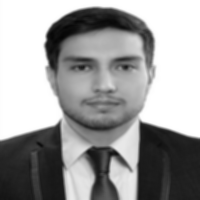

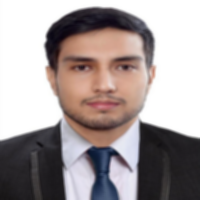

In [ ]:
#foto no se encuentra en el dataset de entrenamiento ni validación
cv2_imshow(imagen_nueva_gray)
cv2_imshow(imagen_nueva)

In [ ]:
categorias = ['ruben', 'daniel']
categorias_array = np.asarray(categorias)

In [ ]:
#MODELO HOG
img_nueva_gray_expand = imagen_nueva_gray.reshape(1,height,width,1)
img_nueva_hog = hog_features2(img_nueva_gray_expand)
fd = np.asarray(img_nueva_hog)
resultado = MLP_model_hog.predict(fd)
print(resultado)
print('La persona de la foto es: {}'.format(categorias_array[resultado.astype(int)]))


(200, 200)
Vector de caracteristicas imagen: (86436,)
Foto #:0
[1]
La persona de la foto es: ['daniel']


# **SIFT**

In [ ]:
def sift_descriptors(imagenes):
  descriptores_lista = []
   
  for i in range(len(imagenes)):
    sift = cv2.SIFT.create()
    kp, desc = sift.detectAndCompute(imagenes[i], None)
    descriptores_lista.append((i, desc))

  return descriptores_lista


def bow(numbers_cluster, imagenes, descriptores_lista, voc):

  im_features = np.zeros((len(imagenes),numbers_cluster),"float32")

  for i in range(len(imagenes)):
    words, distance = vq(descriptores_lista[i][1],voc)
    for w in words:
        im_features[i][w]+=1

  return im_features


In [ ]:
#  DESCRIPTORES SIFT ENTRENAMIENTO

desc_train_list = sift_descriptors(x_train)

descriptores_ordenados = desc_train_list[0][1]

for i, desc in desc_train_list[1:0]:
    descriptores_ordenados = np.vstack((descriptores_ordenados, desc))

descriptors_train = descriptores_ordenados.astype(float)

print('Descriptores de entrenamiento: ', descriptors_train.shape)

Descriptores de entrenamiento:  (62, 128)


In [ ]:
# VALIDACION

desc_test_list = sift_descriptors(x_test)

In [ ]:
#  KMEANS

k = 13

voc,variance = kmeans(descriptors_train, k ,1)


In [ ]:
# BAG OF WORDS Y ESCALONAMIENTO DE LOS DATOS

# -------------------- ENTRENAMIENTO

train_features = bow(k, x_train, desc_train_list, voc)

stdslr = StandardScaler().fit(train_features)

train_features = stdslr.transform(train_features)

print('train_features: ', train_features.shape)

# -------------------- VALIDACION

test_features = bow(k, x_test, desc_test_list, voc)

test_features = stdslr.transform(test_features)

print('test_features: ', test_features.shape)

train_features:  (117, 13)
test_features:  (30, 13)


# **ANN MLP SIFT**

In [ ]:
training_accuracy = []
test_accuracy = []

MLP_sift_default = MLPClassifier()
MLP_sift_default.fit(train_features,np.array(y_train))

training_accuracy.append(MLP_sift_default.score(train_features,np.array(y_train)))
test_accuracy.append(MLP_sift_default.score(test_features,np.array(y_test)))

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [ ]:
MLP_sift_default.get_params(deep=True)

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [ ]:
print("Training set score: {:.2f}".format(MLP_sift_default.score(train_features,np.array(y_train))))
print("Test set score: {:.2f}".format(MLP_sift_default.score(test_features,np.array(y_test))))

Training set score: 1.00
Test set score: 0.93


In [ ]:
training_accuracy = []
test_accuracy = []

hidden_layer_sizes = (100,)
activation = 'relu'                    #{identity, logistic, tanh, relu}
learning_rate = 'constant'                 #{constant, invscaling, adaptive -> SOLO CON sgd’}
max_iter = 200
momentum = 0.9                           #(0 a 1) SE CAMBIA CUANDO SE USA sgd
n_iter_no_change = 10                    #Only effective when solver=’sgd’ or ‘adam’
solver = 'adam'                         #{lbfgs, sgd, adam}


MLP_sift1 = MLPClassifier(hidden_layer_sizes = hidden_layer_sizes, activation = activation, learning_rate = learning_rate, 
                     max_iter = max_iter, momentum = momentum, n_iter_no_change = n_iter_no_change, 
                     solver = solver, random_state=1)


MLP_sift1.fit(train_features,np.array(y_train))

training_accuracy.append(MLP_sift1.score(train_features,np.array(y_train)))
test_accuracy.append(MLP_sift1.score(test_features,np.array(y_test)))

print("Training set score: {:.2f}".format(MLP_sift1.score(train_features,np.array(y_train))))
print("Test set score: {:.2f}".format(MLP_sift1.score(test_features,np.array(y_test))))

Training set score: 1.00
Test set score: 0.90


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [ ]:
training_accuracy = []
test_accuracy = []

hidden_layer_sizes = (100,)
activation = 'relu'                    #{identity, logistic, tanh, relu}
learning_rate = 'constant'                 #{constant, invscaling, adaptive -> SOLO CON sgd’}
max_iter = 500
momentum = 0.9                           #(0 a 1) SE CAMBIA CUANDO SE USA sgd
n_iter_no_change = 10                    #Only effective when solver=’sgd’ or ‘adam’
solver = 'adam'                         #{lbfgs, sgd, adam}


MLP_sift2 = MLPClassifier(hidden_layer_sizes = hidden_layer_sizes, activation = activation, learning_rate = learning_rate, 
                     max_iter = max_iter, momentum = momentum, n_iter_no_change = n_iter_no_change, 
                     solver = solver, random_state=1)

MLP_sift2.fit(train_features,np.array(y_train))

y_pred_val = MLP_sift2.predict(test_features)

In [ ]:
from sklearn.metrics import confusion_matrix # y_test is the groundtruth
cm = confusion_matrix(y_test, y_pred_val)
display(cm)

array([[15,  2],
       [ 2, 11]])

In [ ]:
nombres_test = salida_nombres(y_test)
print(len(nombres_test), len(y_test))
print(y_test)
print(nombres_test)

print('')

nombres_predic = salida_nombres(y_pred_val)
print(len(y_pred_val), len(nombres_predic))
print(y_pred_val)
print(nombres_predic)

30 30
[1 0 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 1 1 0]
['daniel', 'ruben', 'daniel', 'ruben', 'daniel', 'ruben', 'daniel', 'ruben', 'daniel', 'ruben', 'ruben', 'daniel', 'daniel', 'ruben', 'daniel', 'ruben', 'ruben', 'ruben', 'daniel', 'ruben', 'ruben', 'daniel', 'ruben', 'daniel', 'ruben', 'ruben', 'ruben', 'daniel', 'daniel', 'ruben']

30 30
[1 0 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 0 1 1 0 1 0 1 0 0 0 1 1 0]
['daniel', 'ruben', 'daniel', 'ruben', 'daniel', 'ruben', 'daniel', 'ruben', 'daniel', 'ruben', 'ruben', 'daniel', 'daniel', 'ruben', 'daniel', 'ruben', 'ruben', 'ruben', 'daniel', 'daniel', 'ruben', 'daniel', 'ruben', 'daniel', 'ruben', 'ruben', 'ruben', 'daniel', 'daniel', 'ruben']


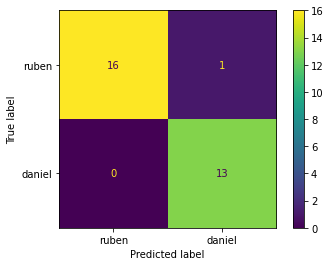

Training set score: 1.00
Test set score: 0.97

ACCURACY:  0.9666666666666667


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

cm = confusion_matrix(nombres_test, nombres_predic, labels=['ruben', 'daniel'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['ruben', 'daniel'])

disp.plot()
plt.show()

print("Training set score: {:.2f}".format(MLPC.score(train_features, y_train)))
print("Test set score: {:.2f}".format(MLPC.score(test_features, y_test)))

print('')

print('ACCURACY: ', accuracy_score(y_test, y_pred_val))

# **SURF**

In [ ]:
def surf_descriptors(imagenes):
  descriptores_lista = []
  hessianTreshold = 400

  for i in range(len(imagenes)):
    surf = cv2.xfeatures2d.SURF_create(hessianTreshold)
    kp, desc = surf.detectAndCompute(imagenes[i], None)
    descriptores_lista.append((i, desc))

  return descriptores_lista


def bow(numbers_cluster, imagenes, descriptores_lista, voc):

  im_features = np.zeros((len(imagenes),numbers_cluster),"float32")

  for i in range(len(imagenes)):
    words, distance = vq(descriptores_lista[i][1],voc)
    for w in words:
        im_features[i][w]+=1

  return im_features

In [ ]:
#  DESCRIPTORES SURF ENTRENAMIENTO

desc_train_list = surf_descriptors(x_train)

descriptores_ordenados = desc_train_list[0][1]

for i, desc in desc_train_list[1:0]:
    descriptores_ordenados = np.vstack((descriptores_ordenados, desc))

descriptors_train = descriptores_ordenados.astype(float)

print('descriptores de entrenamiento: ', descriptors_train.shape)

descriptores de entrenamiento:  (81, 64)


In [ ]:
# VALIDACION

desc_test_list = surf_descriptors(x_test)

In [ ]:
#  KMEANS

k = 13

voc,variance = kmeans(descriptors_train, k ,1)

In [ ]:
# BAG OF WORDS Y ESCALONAMIENTO DE LOS DATOS

# -------------------- ENTRENAMIENTO

train_features = bow(k, x_train, desc_train_list, voc)

stdslr = StandardScaler().fit(train_features)

train_features = stdslr.transform(train_features)

print('train_featues: ', train_features.shape)

# -------------------- VALIDACION

test_features = bow(k, x_test, desc_test_list, voc)

test_features = stdslr.transform(test_features)

print('test_features: ', test_features.shape)

train_featues:  (117, 13)
test_features:  (30, 13)


# **ANN MLP SURF**

In [ ]:
training_accuracy = []
test_accuracy = []

MLPC = MLPClassifier()
MLPC.fit(train_features,np.array(y_train))

training_accuracy.append(MLPC.score(train_features,np.array(y_train)))
test_accuracy.append(MLPC.score(test_features,np.array(y_test)))

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [ ]:
MLPC.get_params(deep=True)

In [ ]:
print("Training set score: {:.2f}".format(MLPC.score(train_features,np.array(y_train))))
print("Test set score: {:.2f}".format(MLPC.score(test_features,np.array(y_test))))

Training set score: 1.00
Test set score: 0.93


In [ ]:
training_accuracy = []
test_accuracy = []

hidden_layer_sizes = (100,)
activation = 'relu'                    #{identity, logistic, tanh, relu}
learning_rate = 'constant'                 #{constant, invscaling, adaptive -> SOLO CON sgd’}
max_iter = 500
momentum = 0.9                           #(0 a 1) SE CAMBIA CUANDO SE USA sgd
n_iter_no_change = 10                    #Only effective when solver=’sgd’ or ‘adam’
solver = 'adam'                         #{lbfgs, sgd, adam}


MLPC = MLPClassifier(hidden_layer_sizes = hidden_layer_sizes, activation = activation, learning_rate = learning_rate, 
                     max_iter = max_iter, momentum = momentum, n_iter_no_change = n_iter_no_change, 
                     solver = solver, random_state=1)


MLPC.fit(train_features,np.array(y_train))

training_accuracy.append(MLPC.score(train_features,np.array(y_train)))
test_accuracy.append(MLPC.score(test_features,np.array(y_test)))

print("Training set score: {:.2f}".format(MLPC.score(train_features,np.array(y_train))))
print("Test set score: {:.2f}".format(MLPC.score(test_features,np.array(y_test))))

Training set score: 1.00
Test set score: 0.93


In [ ]:
training_accuracy = []
test_accuracy = []

hidden_layer_sizes = (500,500,100)
activation = 'relu'                    #{identity, logistic, tanh, relu}
learning_rate = 'constant'                 #{constant, invscaling, adaptive -> SOLO CON sgd’}
max_iter = 500
momentum = 0.9                           #(0 a 1) SE CAMBIA CUANDO SE USA sgd
n_iter_no_change = 10                    #Only effective when solver=’sgd’ or ‘adam’
solver = 'adam'                         #{lbfgs, sgd, adam}


MLPC = MLPClassifier(hidden_layer_sizes = hidden_layer_sizes, activation = activation, learning_rate = learning_rate, 
                     max_iter = max_iter, momentum = momentum, n_iter_no_change = n_iter_no_change, 
                     solver = solver, random_state=1)

MLPC.fit(train_features,np.array(y_train))

y_pred_val = MLPC.predict(test_features)

In [ ]:
from sklearn.metrics import confusion_matrix # y_test is the groundtruth
cm = confusion_matrix(y_test, y_pred_val)
display(cm)

array([[17,  0],
       [ 1, 12]])

In [ ]:
nombres_test = salida_nombres(y_test)
print(len(nombres_test), len(y_test))
print(y_test)
print(nombres_test)

print('')

nombres_predic = salida_nombres(y_pred_val)
print(len(y_pred_val), len(nombres_predic))
print(y_pred_val)
print(nombres_predic)

30 30
[1 0 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 1 1 0]
['daniel', 'ruben', 'daniel', 'ruben', 'daniel', 'ruben', 'daniel', 'ruben', 'daniel', 'ruben', 'ruben', 'daniel', 'daniel', 'ruben', 'daniel', 'ruben', 'ruben', 'ruben', 'daniel', 'ruben', 'ruben', 'daniel', 'ruben', 'daniel', 'ruben', 'ruben', 'ruben', 'daniel', 'daniel', 'ruben']

30 30
[1 0 1 0 1 0 0 0 1 0 0 1 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 1 1 0]
['daniel', 'ruben', 'daniel', 'ruben', 'daniel', 'ruben', 'ruben', 'ruben', 'daniel', 'ruben', 'ruben', 'daniel', 'daniel', 'ruben', 'daniel', 'ruben', 'ruben', 'ruben', 'daniel', 'ruben', 'ruben', 'daniel', 'ruben', 'daniel', 'ruben', 'ruben', 'ruben', 'daniel', 'daniel', 'ruben']


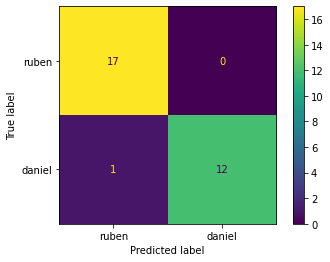

Training set score: 1.00
Test set score: 0.97

ACCURACY:  0.9666666666666667


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

cm = confusion_matrix(nombres_test, nombres_predic, labels=['ruben', 'daniel'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['ruben', 'daniel'])

disp.plot()
plt.show()

print("Training set score: {:.2f}".format(MLPC.score(train_features, y_train)))
print("Test set score: {:.2f}".format(MLPC.score(test_features, y_test)))

print('')

print('ACCURACY: ', accuracy_score(y_test, y_pred_val))

#**COMPARACION DE RESULTADOS**

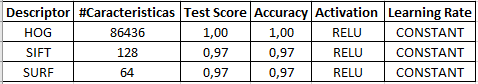

# **CONCLUSIONES**



*   El SIFT y el SURF al generar distintos tamaños de descriptores, obliga a realizar una clusterizacion de dichos datos, haciendo que el proceso se vuelva mas tedioso, aunque los resultados son satisfactorios y el proceso es rapido.

*   El HOG al basarse en histogramas de gradientes, todos los datos seran de igual tamaño pero su numero aumenta, esto hace que el proceso sea un poco menos rapido en comparacion con SIFT y SURF.

* Tanto SIFT SURF y HOG son invariantes en escala y rotación, pero sus principales diferencias se encuentran en que el SIFT y SURF se usan principalmente para detectar caracteristicas locales (describe un parche en la imagen) mientras que HOG para detectar caracteristicas globales (describe la imagen completa).

* Un descriptor local utiliza múltiples descriptores locales para hacer coincidir una imagen, no es necesario que todos los descriptores coincidan para que se realice la comparación. Esto los hace más resistentes a los cambios entre las imágenes coincidentes mientras que el descriptor global no es muy robustos ante los cambios, ya que un cambio en una parte de la imagen puede hacer que falle, ya que afectará al descriptor resultante.






